# First background proposal

**Goal:** in the Bkg-investigations nb, we checked the 2b distributions with some lower stats, but now I'm in the place where we would like to *quantify* this a bit more and in particular, see if some 1d rw templates might be sufficient / useful.

In [1]:
import os
os.sys.path+= ['../RRevolution/code/','../code/','../PAG-opt/','../non-resonant-studies/']
from analysis import getXhh,getRegions
from plots import draw_SR, draw_VR, draw_CR
from utils import mcToYr
from eventDisplays import rainbow_text

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot
import awkward as ak
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

import matplotlib.pyplot as plt
from matplotlib import gridspec

from lim_utils import mu_finder

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
yr=17

mhh_cutoff=350

fname = f'../data/RR/nom_trigs_unblind/data{yr}_min_dR_VEC_sr_124_117.root'

tname='everything'
cut_str = f'(m_hh<{mhh_cutoff}) & (~ pass_vbf_sel)'

In [3]:
figDir = f'figures/data{yr}-JUN20/firstEst_m_hh_{mhh_cutoff}/'

In [4]:
cols = ['pass_vbf_sel', 'ntag', #'truth_mhh', 'njets', 'kinematic_region',
        #'bucket_passed', 'cos_theta_star', 'm_hh_cor', 'trig_bucket',
        'm_hh', 'X_wt_tag', #'pt_hh','dEta_hh',  
        'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1', 
        'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 
        'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1', 'phi_h2_j1',
        'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2']#, 
        #'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2']

In [5]:
t = uproot.open(f'{fname}:{tname}') 

In [6]:
chunk_size = 1000000

In [7]:
cedg = np.arange(0,t.num_entries+chunk_size,chunk_size)
cedg

array([       0,  1000000,  2000000,  3000000,  4000000,  5000000,
        6000000,  7000000,  8000000,  9000000, 10000000, 11000000,
       12000000, 13000000, 14000000, 15000000, 16000000, 17000000,
       18000000, 19000000, 20000000, 21000000, 22000000, 23000000,
       24000000, 25000000, 26000000, 27000000, 28000000, 29000000,
       30000000, 31000000, 32000000, 33000000, 34000000, 35000000,
       36000000, 37000000, 38000000])

In [8]:
uproot.__version__

'4.0.4'

In [9]:
def getPairComb(dfi):
    '''
    Goal: Run through the analysis to select the pair that minimizes the
    dRjj_h1 b/w the 2 pairs
    '''
    
    # Construct 4-vecotrs
    j4 = ak.zip(
        {
            "pt":  dfi[[f'pT_h{i}_j{j}'  for i,j in product([1,2],[1,2])]].values,
            "eta": dfi[[f'eta_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,
            "phi": dfi[[f'phi_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,
            "energy":   dfi[[f'E_h{i}_j{j}'   for i,j in product([1,2],[1,2])]].values,
        },
        with_name="PtEtaPhiELorentzVector",
    )
    
    # Get all possible pairings
    for pi,i11,i12,i21,i22 in zip(range(3),[0,0,0],[1,2,3], [2,1,1],[3,3,2]):

        h1 = j4[:,i11] + j4[:,i12]
        h2 = j4[:,i21] + j4[:,i22]

        dR1 = j4[:,i11].delta_r(j4[:,i12])
        dR2 = j4[:,i21].delta_r(j4[:,i22])
        dfi[f'pair{pi}_dRjj_h1'] = np.where(h1.pt > h2.pt, dR1, dR2)
        dfi[f'pair{pi}_dRjj_h2'] = np.where(h1.pt < h2.pt, dR1, dR2)

        # Save the 4-vector info 
        dfi[f'pair{pi}_deta_hh'] = abs(h1.eta - h2.eta)


        dfi[f'pair{pi}_m_h1'] = np.where(h1.pt > h2.pt, h1.mass, h2.mass)
        dfi[f'pair{pi}_m_h2'] = np.where(h1.pt < h2.pt, h1.mass, h2.mass)

    # Constuct all combinations of 2 pairs
    dfi[f'comb0_dR1diff'] = np.abs(dfi[f'pair1_dRjj_h1'] - dfi[f'pair2_dRjj_h1'])
    dfi[f'comb1_dR1diff'] = np.abs(dfi[f'pair0_dRjj_h1'] - dfi[f'pair2_dRjj_h1'])
    dfi[f'comb2_dR1diff'] = np.abs(dfi[f'pair0_dRjj_h1'] - dfi[f'pair1_dRjj_h1'])
    
    # Get the pair that min the dR1 diff
    comb_i = np.argmin(dfi[[f'comb{i}_dR1diff' for i in range(3)]].values,axis=1)

    # Save the output vars to define the massplane and fit deta_hh
    for i, p1,p2 in zip(range(3),[1,0,0],[2,2,1]): 
        m = comb_i==i
        for v in ['deta_hh','m_h1','m_h2']:
            dfi.loc[m,f'{v}_avg'] = 0.5*np.sum(dfi.loc[m,[f'pair{p1}_{v}',f'pair{p2}_{v}']],axis=1)

In [10]:
save_cols = ['ntag','m_hh','deta_hh_avg','m_h1_avg','m_h2_avg']

In [11]:
for cmin, cmax in tqdm(zip(cedg[:-1],cedg[1:])):
    
    dfi = t.arrays(cols,cut=cut_str,entry_start=cmin,entry_stop=cmax,library='pd')
    getPairComb(dfi)
    
    if cmin == 0:
        df = dfi[save_cols]
    else:
        df.append(dfi,ignore_index=True)

38it [01:45,  2.78s/it]


In [12]:
x1,y1 = 124,117

In [13]:
getRegions(df,x1,y1,'m_h1_avg','m_h2_avg',kr='kr_avg')

Draw the (blinded) 4b massplane.

In [14]:
plt.hist2d(*df.loc[(df.ntag>=4) & (df.kr_avg!=0),['m_h1_avg','m_h2_avg']].values.T,
           25,[(50,200),(50,200)],cmap='YlGnBu')

plt.colorbar()
plt.xlabel('m_h1')
plt.ylabel('m_h2')

for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')

plt.title('4b re-"paired"')
plt.show()

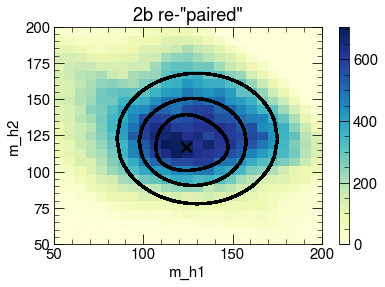

In [15]:
plt.hist2d(*df.loc[(df.ntag==2),['m_h1_avg','m_h2_avg']].values.T,
           25,[(50,200),(50,200)],cmap='YlGnBu')

plt.colorbar()
plt.xlabel('m_h1')
plt.ylabel('m_h2')

for f in [draw_SR,draw_VR,draw_CR]:
    xx,yy = f(x1,y1)
    plt.plot(xx,yy,'k-')
plt.scatter([x1],[y1],100,color='k',marker='x')

plt.title('2b re-"paired"')
plt.show()

Wow - these are *crazy* low stats!!

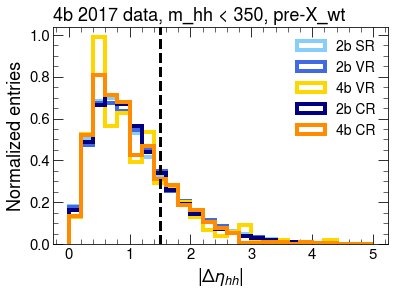

In [16]:
for i,reg,ls,c_2b,c_4b in zip(range(3),['SR','VR','CR'],['-','--','dotted'],
                              ['lightskyblue','royalblue','navy'],['lightskyblue','gold','darkorange']):

    
    plt.hist(df.loc[(df.ntag==2) & (df.kr_avg==i),'deta_hh_avg'],25,(0,5),
             histtype='step',lw=4,color=c_2b,label=f'2b {reg}',density=True)
    
    if i == 0: continue
    plt.hist(df.loc[(df.ntag>=4) & (df.kr_avg==i),'deta_hh_avg'],25,(0,5),
             histtype='step',lw=4,color=c_4b,label=f'4b {reg}',density=True)

plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
plt.ylabel('Normalized entries',fontsize=18)
plt.legend()
plt.title(f'4b 20{yr} data, m_hh < {mhh_cutoff}, pre-X_wt',loc='left')

ylim = plt.ylim()
plt.plot([1.5]*2, ylim,'k--')
plt.ylim(ylim)

plt.show()

Ok, I will *probably* want to smooth these 4b templates for a "hacky" version of the reweighting.

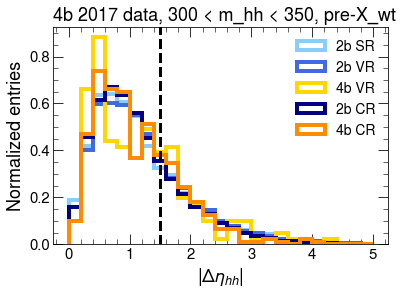

In [17]:
for mmin,mmax in zip([200,300],[300,350]):

    plt.figure()
    
    for i,reg,ls,c_2b,c_4b in zip(range(3),['SR','VR','CR'],['-','--','dotted'],
                                  ['lightskyblue','royalblue','navy'],['lightskyblue','gold','darkorange']):

        m = (df.m_hh > mmin) & (df.m_hh < mmax) & (df.kr_avg==i)
        
        plt.hist(df.loc[(df.ntag==2) & m,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c_2b,label=f'2b {reg}',density=True)

        if i == 0: continue
        plt.hist(df.loc[(df.ntag>=4) & m,'deta_hh_avg'],25,(0,5),
                 histtype='step',lw=4,color=c_4b,label=f'4b {reg}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized entries',fontsize=18)
    plt.legend()
    plt.title(f'4b 20{yr} data, {mmin} < m_hh < {mmax}, pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

    plt.show()

Woah - this bin from 300 - 350 GeV is *quite* wonky... let's try rebinning it!!

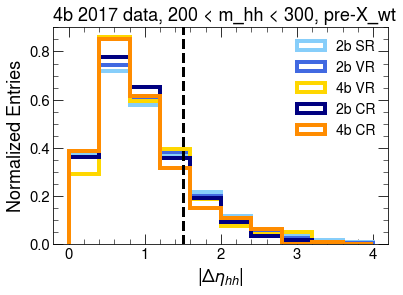

In [18]:
for mmin,mmax in zip([200,300],[300,350]):

    plt.figure()
    
    for i,reg,ls,c_2b,c_4b in zip(range(3),['SR','VR','CR'],['-','--','dotted'],
                                  ['lightskyblue','royalblue','navy'],['lightskyblue','gold','darkorange']):

        m = (df.m_hh > mmin) & (df.m_hh < mmax) & (df.kr_avg==i)
        
        plt.hist(df.loc[(df.ntag==2) & m,'deta_hh_avg'],10,(0,4),
                 histtype='step',lw=4,color=c_2b,label=f'2b {reg}',density=True)

        if i == 0: continue
        plt.hist(df.loc[(df.ntag>=4) & m,'deta_hh_avg'],10,(0,4),
                 histtype='step',lw=4,color=c_4b,label=f'4b {reg}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized Entries',fontsize=18)
    plt.legend()
    plt.title(f'4b 20{yr} data, {mmin} < m_hh < {mmax}, pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

    plt.show()

Ok, I doubled the bin sizes, but there's still *large* and a bit wonky dip.

Let's try *varying* the m_hh cutoff to keep = proportions for X and Y.

In [19]:
mhh_cuts = np.linspace(200,350,10)

keys = [f'{r}_{ntag}b_{s}' for r,ntag,s in product(['SR','VR','CR'],[2,4],['up','dn'])]
y = {k:[] for k in keys}

for mi in mhh_cuts:
    
    for i,r in enumerate(['SR','VR','CR']):
    
        m_2b = (df.kr_avg==i) & (df.ntag==2)
        y[f'{r}_2b_dn'].append(np.sum(m_2b & (df.m_hh < mi))/np.sum(m_2b))
        y[f'{r}_2b_up'].append(np.sum(m_2b & (df.m_hh > mi))/np.sum(m_2b))
    
        if i ==0: continue
        m_4b = (df.kr_avg==i) & (df.ntag>=4)
        y[f'{r}_4b_dn'].append(np.sum(m_4b & (df.m_hh < mi))/np.sum(m_4b))
        y[f'{r}_4b_up'].append(np.sum(m_4b & (df.m_hh > mi))/np.sum(m_4b))

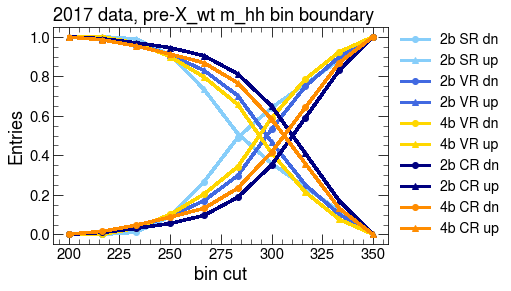

In [20]:
for i,r,c_2b,c_4b in zip(range(3),['SR','VR','CR'],
                              ['lightskyblue','royalblue','navy'],
                              ['lightskyblue','gold','darkorange']):

    #plt.figure()
    plt.plot(mhh_cuts,y[f'{r}_2b_dn'],marker='o',color=c_2b,label=f'2b {r} dn')
    plt.plot(mhh_cuts,y[f'{r}_2b_up'],marker='^',color=c_2b,label=f'2b {r} up')
    
    if i == 0: continue
    plt.plot(mhh_cuts,y[f'{r}_4b_dn'],marker='o',color=c_4b,label=f'4b {r} dn')
    plt.plot(mhh_cuts,y[f'{r}_4b_up'],marker='^',color=c_4b,label=f'4b {r} up')

plt.xlabel('bin cut',fontsize=18)    
plt.ylabel('Entries',fontsize=18)
plt.legend(bbox_to_anchor=(1,1.03))
plt.title(f'20{yr} data, pre-X_wt m_hh bin boundary',loc='left')

plt.show()

**Conclusion:** Let's just *try* 290 for the cutoff.

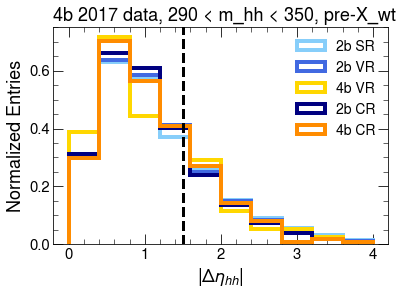

In [21]:
for mmin,mmax in zip([200,290],[290,350]):

    plt.figure()
    
    for i,reg,ls,c_2b,c_4b in zip(range(3),['SR','VR','CR'],['-','--','dotted'],
                                  ['lightskyblue','royalblue','navy'],['lightskyblue','gold','darkorange']):

        m = (df.m_hh > mmin) & (df.m_hh < mmax) & (df.kr_avg==i)
        
        plt.hist(df.loc[(df.ntag==2) & m,'deta_hh_avg'],10,(0,4),
                 histtype='step',lw=4,color=c_2b,label=f'2b {reg}',density=True)

        if i == 0: continue
        plt.hist(df.loc[(df.ntag>=4) & m,'deta_hh_avg'],10,(0,4),
                 histtype='step',lw=4,color=c_4b,label=f'4b {reg}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized Entries',fontsize=18)
    plt.legend()
    plt.title(f'4b 20{yr} data, {mmin} < m_hh < {mmax}, pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

    plt.show()

Ok - this is *not great* and either way it will *prob* translate into a large uncertainty, but hopefully this is something we can deal with??

It'll be interesting to *check* the other years as well to see if this has an impact there too.

**Just for fun... let's try a GP fit to *smooth* out some of these 4b histograms.**

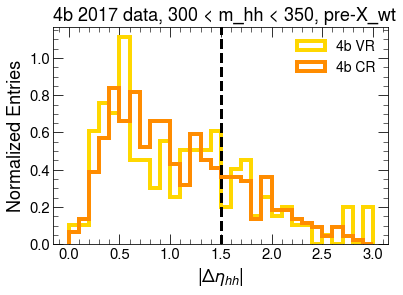

In [22]:
h_4b = {}

for mmin,mmax in zip([200,300],[300,350]):

    plt.figure()
    
    for i,reg,c_4b in zip([1,2],['VR','CR'],['gold','darkorange']):

        m = (df.m_hh > mmin) & (df.m_hh < mmax) & (df.kr_avg==i)

        n,e,_ = plt.hist(df.loc[(df.ntag>=4) & m,'deta_hh_avg'],30,(0,3),
                         histtype='step',lw=4,color=c_4b,
                         label=f'4b {reg}',density=True)

        h_4b[f'{reg}_{mmin}_{mmax}'] = n
        
    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized Entries',fontsize=18)
    plt.legend()
    plt.title(f'4b 20{yr} data, {mmin} < m_hh < {mmax}, pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

    plt.show()

Like I feel like I can kind of see by eye what bandwidth we *want* to use, so I think now it's just a matter of turning this into a prediction.

Let's start off peeking at Sean's GP code!!

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [24]:
hi = h_4b[f'{reg}_{mmin}_{mmax}']

In [25]:
mu = np.mean(hi)
std = np.std(hi)

In [26]:
kern = RBF(length_scale=[1], length_scale_bounds=(1,3))
gpr = GaussianProcessRegressor(kernel=kern) #alpha=norm_stat_err[blind])

In [27]:
xx = 0.5 * (e[1:] + e[:-1])
xx = xx.reshape(-1,1)

In [28]:
gpr.fit(xx,(hi-mu)/std)

GaussianProcessRegressor(kernel=RBF(length_scale=1))

In [29]:
gpr.kernel_

RBF(length_scale=1)

It wants a *crazy* small length scale unless I manually bound it. 

In [30]:
x_fine = np.linspace(0,3,100).reshape(-1,1)

Hmmmmmm - the error is *almost always 1*... what does this mean???

And what about the points that dip lower???

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


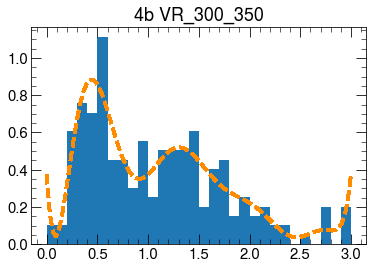

/u/ki/nhartman/gpfs/miniconda3/envs/my_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [31]:
for k,hi in h_4b.items():
    
    
    kern = RBF(length_scale=[1], length_scale_bounds=(1,3))
    gpr = GaussianProcessRegressor(kernel=kern)#,alpha=0.001*np.sqrt(hi))
    
    gpr.fit(xx,(hi-mu)/std)
    
    (h_fit, h_unc) = gpr.predict(x_fine, return_std=True)

    plt.plot(x_fine.squeeze(),mu+std*h_fit,color='darkorange',ls='--')
    plt.hist(xx,30,(0,3),weights=hi)
    plt.title('4b '+k)
    plt.show()

Ok - this seems reasonable if I inncrease the length scale to 1, although it is a bit ad-hoc haha.

**Plan:** Interpolate using the midpoint rule.

In [32]:
gp_4b = {}

30


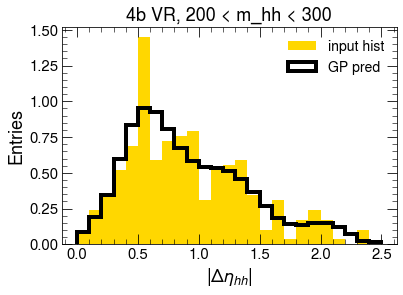

30


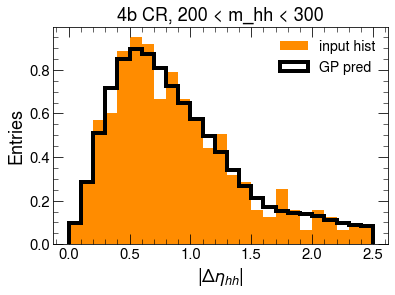

30


30


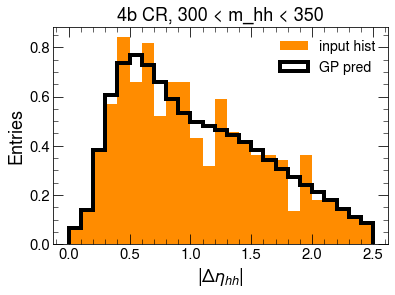

In [33]:
for k,hi in h_4b.items():
    
    r,mmin,mmax = k.split('_')
    
    c = 'gold' if r == 'VR' else 'darkorange'
     
    plt.hist(xx,25,(0,2.5),weights=hi,color=c,label='input hist')
    
    kern = RBF(length_scale=[1], length_scale_bounds=(1,3))
    gpr = GaussianProcessRegressor(kernel=kern)#,alpha=0.001*np.sqrt(hi))
    
    gpr.fit(xx,(hi-mu)/std)
    
    (h_fit, h_unc) = gpr.predict(xx, return_std=True)
    pred = mu+std*h_fit
    
    gp_4b[k] = pred
    print(len(pred))
    plt.hist(xx,25,(0,2.5),weights=pred,
             color='k',histtype='step',label='GP pred',lw=4)    
    
    plt.title(f'4b {r}, {mmin} < m_hh < {mmax}')
    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend()
    plt.show()

note - when I extended these histograms out to 3, the last bin for the VR had a larger entry than *seemed* physical, so I decided to just stop the fit at 2.5 to avoid this effect.

So, these final predictios are - not *great*, but ot awful either. I think this is good enough to keep pushing ahead tho!!


Let's recheck these 2b+4b "compariso" histograms!

In [34]:
h_2b = {}

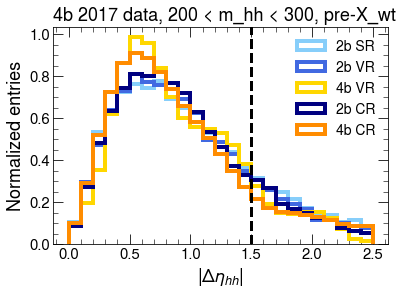

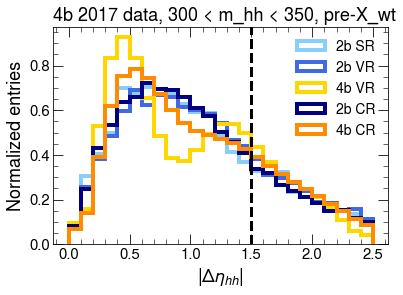

In [35]:
for mmin,mmax in zip([200,300],[300,350]):

    plt.figure()
    
    for i,reg,ls,c_2b,c_4b in zip(range(3),['SR','VR','CR'],['-','--','dotted'],
                                  ['lightskyblue','royalblue','navy'],['lightskyblue','gold','darkorange']):

        k = f'{reg}_{mmin}_{mmax}'
        
        m = (df.m_hh > mmin) & (df.m_hh < mmax) & (df.kr_avg==i)
        
        hi,_,_ = plt.hist(df.loc[(df.ntag==2) & m,'deta_hh_avg'],25,(0,2.5),
                          histtype='step',lw=4,color=c_2b,label=f'2b {reg}',density=True)
        h_2b[k] = hi
        
        if i == 0: continue
    
        plt.hist(xx,25,(0,2.5),weights=gp_4b[k],histtype='step',
                 lw=4,color=c_4b,label=f'4b {reg}',density=True)

    plt.xlabel('$|\Delta \eta_{hh}|$',fontsize=18)    
    plt.ylabel('Normalized entries',fontsize=18)
    plt.legend()
    plt.title(f'4b 20{yr} data, {mmin} < m_hh < {mmax}, pre-X_wt',loc='left')

    ylim = plt.ylim()
    plt.plot([1.5]*2, ylim,'k--')
    plt.ylim(ylim)

    plt.show()

**Next step:** Consider some differect ways to define the uncertaities, i.e:
1. Difference between the CR and VR derived rws in the SR
2. non-closure in the VR

#### Option  1:  Difference in SR

In [36]:
len(gp_4b['VR_200_300'])

30

In [37]:
xi = xx[:25]

Text(0, 0.5, 'Shape histos')

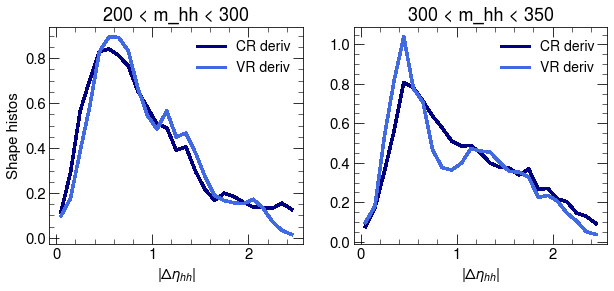

In [38]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

for mmin,mmax,ax in zip([200,300],[300,350],axes):

    k_sr = f'SR_{mmin}_{mmax}'
    k_vr = f'VR_{mmin}_{mmax}'
    k_cr = f'CR_{mmin}_{mmax}'
    
    
    nom = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_sr]
    var = gp_4b[k_vr][:25]/h_2b[k_vr] * h_2b[k_sr]
    
    ax.plot(xx[:25],nom,'navy',label='CR deriv')
    ax.plot(xx[:25],var,'royalblue',label='VR deriv')
    
    ax.set_xlabel('$|\Delta \eta_{hh}|$')
    ax.set_title(f'{mmin} < m_hh < {mmax}')
    ax.legend()
    
axes[0].set_ylabel('Shape histos')

In [39]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

for mmin,mmax,ax in zip([200,300],[300,350],axes):

    k_sr = f'SR_{mmin}_{mmax}'
    k_vr = f'VR_{mmin}_{mmax}'
    k_cr = f'CR_{mmin}_{mmax}'
    
    nom = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_sr]
    var = gp_4b[k_vr][:25]/h_2b[k_vr] * h_2b[k_sr]
    
    ax.plot(xi,var/nom,'lightskyblue')
    ax.plot(xi,2-var/nom,'lightskyblue')
    
    ax.set_xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
    ax.set_ylabel('var / nom',fontsize=16)
    ax.set_title(f'{mmin} < m_hh < {mmax}')
    
    ax.set_ylim(0.5,1.5)

Hmmmm - idk if I trust this - it seems *quite* noisy!!

#### Option  2:  Non-closure in VR

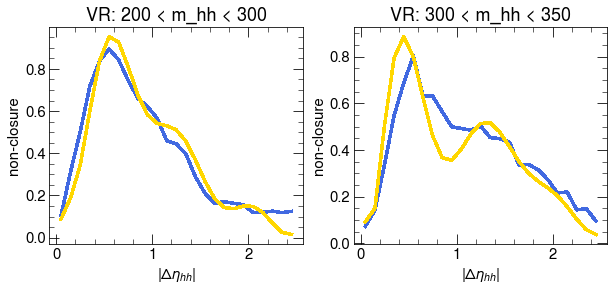

In [40]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

for mmin,mmax,ax in zip([200,300],[300,350],axes):

    k_sr = f'SR_{mmin}_{mmax}'
    k_vr = f'VR_{mmin}_{mmax}'
    k_cr = f'CR_{mmin}_{mmax}'
    
    pred = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_vr]
    obs = gp_4b[k_vr][:25]
    
    ax.plot(xi,pred,color='royalblue')
    ax.plot(xi,obs, color='gold')
    

    ax.set_xlabel('$|\Delta \eta_{hh}|$')
    ax.set_ylabel('non-closure')
    ax.set_title(f'VR: {mmin} < m_hh < {mmax}')
    

Let's compare the two ways to *get* a error bar!

In [41]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

for mmin,mmax,ax in zip([200,300],[300,350],axes):

    k_sr = f'SR_{mmin}_{mmax}'
    k_vr = f'VR_{mmin}_{mmax}'
    k_cr = f'CR_{mmin}_{mmax}'
    
    nom = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_sr]
    var = gp_4b[k_vr][:25]/h_2b[k_vr] * h_2b[k_sr]
    
    ax.plot(xi,var/nom,'lightskyblue')
    ax.plot(xi,2-var/nom,'lightskyblue')
    

    pred = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_vr]
    #obs = h_4b[k_vr][:25]
    obs = gp_4b[k_vr][:25]
    
    
    ax.plot(xi,obs/pred,color='gold',ls='--')
    ax.plot(xi,2-obs/pred, color='gold',ls='--')
    
    
    ax.set_xlabel('$|\Delta \eta_{hh}|$',fontsize=16)
    ax.set_ylabel('var / nom',fontsize=16)
    ax.set_title(f'{mmin} < m_hh < {mmax}')
    
    ax.set_ylim(0.5,1.5)
    
    
    print('var/nom',2-var/nom)
    print('pred/obs',pred/obs)
    

var/nom [1.1515976  1.39600858 1.31493011 1.16571638 1.00059807 0.93559349
 0.90033082 0.91249225 0.9768461  1.06226012 1.0448688  0.84629717
 0.84990141 0.84831797 0.72379491 0.73133375 0.87552871 1.16564176
 1.15304516 1.04202113 0.74326016 1.00556951 1.44789413 1.78598966
 1.87740184]
pred/obs [1.17868596 1.65565265 1.45970507 1.19863315 1.00059843 0.93949068
 0.9093644  0.91953368 0.97737007 1.06639381 1.04697658 0.86677433
 0.86949068 0.86829522 0.78357312 0.78822937 0.88930683 1.19852594
 1.1807005  1.04386436 0.79570964 1.00560071 1.81124683 4.67267145
 8.15672948]
var/nom [0.73046295 0.94508478 0.49888421 0.55079125 0.71256824 1.00525475
 1.00971957 1.26903753 1.34939907 1.28683685 1.17903925 1.03122849
 0.97786173 0.86162198 0.93637923 1.04463924 0.9533046  1.1135628
 1.15653845 1.1284292  1.05455164 1.28458674 1.2790689  1.60804227
 1.60131288]
pred/obs [0.78768871 0.94794347 0.66617113 0.69003172 0.7767402  1.00528251
 1.00981497 1.36805929 1.53704053 1.40220368 1.21808502 1

Cool, ok the GP stuff might be a little dicey, but it's good to know that I'm getting cosistent results w/ these 2 methods rn!!

**Next order of business:** Let's try to 
1. Define a workspace
2. Pop out some limits!!

In [42]:
# First, load in the ws we already made w/ these files
ws_name = f'../stats-results/min_dR_sr_opt_rw/ws-systs-HTcut-300-4b-{yr}-SM-HH-sr-{float(x1):.1f}_{float(y1):.1f}_1.6.json'

In [43]:
ws_name

'../stats-results/min_dR_sr_opt_rw/ws-systs-HTcut-300-4b-17-SM-HH-sr-124.0_117.0_1.6.json'

In [44]:
with open(ws_name,'r') as f:
    ws_in = json.load(f)

In [45]:
ws_in.keys()

dict_keys(['channels', 'observations', 'measurements', 'version'])

Right now, there is only *one* channel, `channel174b`, so what I'm proposing is adding 2 more:
1. `channel174b_mhh_200_300`
2. `channel174b_mhh_300_350`

(But then ofc in parallel, I'll need to also lop off the first 150 / 25 = 6 bins for the workspaces that are already saved.)

Each channel needs to save the signal and background sample, along with the correspondig modifiers.

*Let's focus on the background right now b/c in practice we'll want to run over several different signals.*

In [46]:
ws_in['measurements']

[{'name': 'Measurement',
  'config': {'poi': 'mu',
   'parameters': [{'name': 'mu', 'bounds': [[-1000, 1000000]], 'inits': [1.0]},
    {'name': 'lumi',
     'auxdata': [1.0],
     'sigmas': [0.017],
     'bounds': [[0.915, 1.085]],
     'inits': [1.0]}]}}]

**Define a dictionary with these new bkg hists**

In [47]:
bDict = {}

for mmin,mmax,ax in zip([200,300],[300,350],axes):

    k_sr = f'SR_{mmin}_{mmax}'
    k_vr = f'VR_{mmin}_{mmax}'
    k_cr = f'CR_{mmin}_{mmax}'
    
    nom = gp_4b[k_cr][:25]/h_2b[k_cr] * h_2b[k_sr]
    var = gp_4b[k_vr][:25]/h_2b[k_vr] * h_2b[k_sr]
     
    bi = {}
    bi['data'] = nom
    bi['lo_data'] = var
    bi['hi_data'] = 2*nom - var

    k = f'channel{yr}4b_mhh_{mmin}_{mmax}'
    bDict[k] = bi


**Next:** Save the background hists, but lop off the lowest 6 bins.

**First with both the low + high ht systs**

In [48]:
ws_in['channels'][0]['samples'][1]['modifiers'][2]#['data']

{'name': 'high_HT17_4b',
 'type': 'histosys',
 'data': {'lo_data': [1e-20,
   0.39497882682382174,
   8.54436984085255,
   63.646211609052095,
   227.4230107689448,
   453.37931859763023,
   603.1158244372466,
   580.0652524349113,
   500.9306727175451,
   388.69725969637955,
   294.6988524753457,
   231.22014440945668,
   182.03559774344694,
   149.91174102415152,
   114.17726640481578,
   95.06467371858389,
   77.10412249412866,
   64.7081789744534,
   54.83580511631544,
   41.66391469252267,
   35.34884635562457,
   29.16228449962182,
   24.54741874808542,
   20.906357182384,
   16.174089725774138,
   13.658301926795048,
   11.83665420176385,
   10.561995987790851,
   9.23544671630816,
   9.232179241161703,
   6.3357239267288605,
   5.302268671033744,
   4.438354158452967,
   4.281061914603924,
   3.0523280790675926,
   2.167192148292088,
   1.6974678013089033,
   1.471873183342268,
   1.1048649490585376,
   0.8205817890684557],
  'hi_data': [1e-20,
   0.39497882682382174,
   5.2723

In [49]:
bi = {}

nom = ws_in['channels'][0]['samples'][1]['data'][6:]
bs  = ws_in['channels'][0]['samples'][1]['modifiers'][0]['data'][6:]

bi['data'] = nom
bi['bs_unc'] = bs

lowHT  = ws_in['channels'][0]['samples'][1]['modifiers'][1]['data']
highHT = ws_in['channels'][0]['samples'][1]['modifiers'][2]['data']

# Ok, I'm saving these separately, but Sean said to test the lim > 350, I could j use one
bi['low_HT_lo_data']  =  lowHT['lo_data'][6:]
bi['low_HT_hi_data']  =  lowHT['hi_data'][6:]
bi['high_HT_lo_data'] = highHT['lo_data'][6:]
bi['high_HT_hi_data'] = highHT['hi_data'][6:]

**Then just 1 shape syst for the m_hh > 350 GeV category**

In [73]:
bj = {}

bj['data']   = nom
bj['bs_unc'] = bs

bj['shape_lo_data'] = list(np.array(lowHT['lo_data'][6:]) + np.array(highHT['lo_data'][6:])-nom)
bj['shape_hi_data'] = list(np.array(lowHT['hi_data'][6:]) + np.array(highHT['hi_data'][6:])-nom)

k = f'background174b_350'
bDict[k] = bj


Just for fun, let's visualize these uncertainty limits!!

In [74]:
n = (ws_in['channels'][0]['samples'][1]['data'])

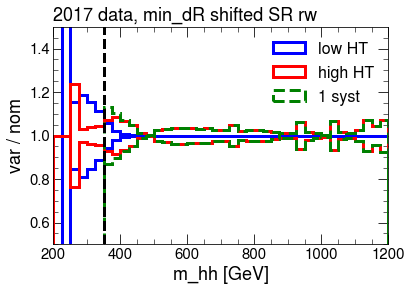

In [75]:
e = np.linspace(200,1200,41)
y = 0.5 * (e[1:]+e[:-1])

plt.hist(y,40,(200,1200),color='b',histtype='step',label='low HT',
         weights=np.array(lowHT['lo_data'])/n,lw=3)
plt.hist(y,40,(200,1200),color='b',histtype='step',
         weights=np.array(lowHT['hi_data'])/n,lw=3)

plt.hist(y,40,(200,1200),color='r',histtype='step',label='high HT',
         weights=np.array(highHT['lo_data'])/n,lw=3)
plt.hist(y,40,(200,1200),color='r',histtype='step',
         weights=np.array(highHT['hi_data'])/n,lw=3)


plt.hist(y[6:],e[6:],color='g',histtype='step',label='1 syst',
         weights=np.array(bj['shape_lo_data'])/nom,lw=3,ls='--')
plt.hist(y[6:],e[6:],color='g',histtype='step',
         weights=np.array(bj['shape_hi_data'])/nom,lw=3,ls='--')


plt.title(f'20{yr} data, min_dR shifted SR rw',loc='left')

plt.legend(fontsize=16)

plt.xlabel('m_hh [GeV]',fontsize=18)
plt.ylabel('var / nom',fontsize=18)
plt.ylim(.5,1.5)
plt.xlim(200,1200)

plt.plot([350]*2,[.5,1.5],'k--')

plt.savefig(f'{figDir}/low_high_HT_syst.pdf',bbox_inches='tight')

plt.show()

Cool, so I showed Sean, and he thought it was "chill" to have *one* shape systematic if I was looking at this cutoff. 

(Although he was saying we should probably retrain w/ the m_hh cut if this is how we want to define the categories.)

How does the low $m_{hh}$ region impact the "baseline" a.k.a, the SM limit??

**Also need the corresponding signal now**

For starters, just truncate the input workspace.


In [53]:
ws_in['channels'][0]['samples'][1]['modifiers'][1]

{'name': 'low_HT17_4b',
 'type': 'histosys',
 'data': {'lo_data': [1e-20,
   0.5955787114496722,
   7.970114623525669,
   73.34747087878647,
   253.0446251793894,
   484.0237676428428,
   595.5939019711059,
   546.9108921172929,
   471.81233370110704,
   371.1510790081916,
   290.9267912003286,
   230.8407089981913,
   186.48608978725952,
   154.2823298935623,
   118.52084674920161,
   98.69257639663374,
   79.80883151248872,
   66.87680382957751,
   56.801476111015745,
   42.765171812437984,
   36.26327860149286,
   30.65585195214453,
   25.03830933816198,
   21.47810623247733,
   16.616182554897023,
   13.984531783569764,
   12.012288166703456,
   10.434199877497576,
   9.12845192958548,
   8.680837187640009,
   6.219504808571401,
   5.245341489018756,
   4.4590311771253255,
   4.007450114246694,
   3.005041573876042,
   2.1460725634360642,
   1.6564135387443457,
   1.3741541456265622,
   1.0593325320919575,
   0.764124090785117],
  'hi_data': [1e-20,
   0.19437894219797125,
   5.846

In [54]:
sDict = {}

sDict[f'signal{yr}4b_350'] = ws_in['channels'][0]['samples'][0]['data'][6:]


In [55]:
import pyhf

In [56]:
#  ws_in['channels'][0]['samples'][0]['name']

In [57]:
def makeWS(keys,sDict,bDict):
    '''
    Goal: Make a *new* workspace combining the 3 separate channels
    for the three m_hh bins.
    
    There *should* be flexbility to just include a limited # of the bins though.
    '''
    
    
    # Measurements - here just for 1 poi
    meas_params = [{ "name": "mu", "bounds": [[-1000, 1000000]], "inits":[1.0] }]
#     meas_params.append({"name":"lumi", 
#                         "auxdata":[1.0],
#                         "sigmas":[0.017], 
#                         "bounds":[[0.915,1.085]],
#                         "inits":[1.0] })
    
    
    specs = {'channels'     : [],
             'observations' : [],
             'measurements' : [{'name': 'Measurement', 
                                'config': { 'poi': 'mu', 'parameters': meas_params } 
                               }],
             'version'      : '1.0.0'}


    for k in keys:
        
        channel = {}
        channel['name'] = f'channel{k}'
        channel['samples'] = []
        
        
        # Signal
        smods = [
             {'name': 'mu', 'type': 'normfactor', 'data': None},
#              {'name': 'lumi', 'type': 'lumi', 'data': None},
#              {'name': 'Theory', 'type': 'normsys', 'data': {'hi': 1.05, 'lo': 0.95}}   
            ]
        
        si = {'name': f'signal{k}', 
              'data': sDict[f'signal{k}'], 
              'modifiers': smods} 
        
        channel['samples'].append(si)
            
        # Background
        bkey = f'background{k}'
        bi = {'name': bkey,
              'data': bDict[bkey]['data']}
        
        bmods = []
        # bootstrap
        bmods.append({
            'name': f'uncorr_bkguncrt{k}',
            'type': 'shapesys',
            'data': bDict[bkey]['bs_unc'],
        })
        
        #shape
        bmods.append({
            'name': f'shape{k}',
            'type': 'histosys',
            'data': {
                'lo_data': bDict[bkey]['shape_lo_data'],
                'hi_data': bDict[bkey]['shape_hi_data'] 
                },
        })
        
        
        #norm?
#         bmods.append('name': f'bkg_norm{k}',
#                      'type': 'normsys',
#                      'data': {'lo': 0.9942555785501436, 
#                               'hi': 1.0057444214498565})
        
        
        bi['modifiers'] = bmods
        
        
        channel['samples'].append(bi)
        
        
        # One channel j needs S and B
        specs['channels'].append(channel)
        
                
        # For "observations" - j include the nominal bkg estimate
        specs['observations'].append({'name': f'channel{k}',
                                      'data': bDict[bkey]['data']})
    
    
        # Save the ws to a .json file?
    #return specs
    return pyhf.Workspace(specs)

In [76]:
ws_test = makeWS(['174b_350'],sDict,bDict)

Then - it's easy to get the pyhf model from the workspace.

In [77]:
m = ws_test.model(
        measurement_name="Measurement",
        modifier_settings={
            "normsys": {"interpcode": "code4"},
            "histosys": {"interpcode": "code4p"},
        },
    )

d = ws_test.data(m)

In [78]:
len(ws_test.data(m))

69

In [79]:
inits = m.config.suggested_init()
inits[ m.config.poi_index ] = 0.0

In [80]:
len(inits)

36

In [81]:
asi_data = m.expected_actualdata(inits)

In [82]:
asi_data

array([562.51996674, 535.4373148 , 469.20378838, 370.84746134,
       290.89612372, 230.84186663, 186.48608979, 154.28232989,
       118.52084675,  98.6925764 ,  79.80883151,  66.87680383,
        56.80147611,  42.76517181,  36.2632786 ,  30.65585195,
        25.03830934,  21.47810623,  16.61618255,  13.98453178,
        12.01228817,  10.43419988,   9.12845193,   8.68083719,
         6.21950481,   5.24534149,   4.45903118,   4.00745011,
         3.00504157,   2.14607256,   1.65641354,   1.37415415,
         1.05933253,   0.76412409])

In [83]:
# bDict['background174b_350']

In [84]:
bDict['background174b_350']['data']

[562.5199667360055,
 535.4373147995059,
 469.20378837693715,
 370.8474613418831,
 290.8961237179816,
 230.84186663467653,
 186.48608978725952,
 154.2823298935623,
 118.52084674920161,
 98.69257639663374,
 79.80883151248872,
 66.87680382957751,
 56.801476111015745,
 42.765171812437984,
 36.26327860149286,
 30.65585195214453,
 25.03830933816198,
 21.47810623247733,
 16.616182554897023,
 13.984531783569764,
 12.012288166703456,
 10.434199877497576,
 9.12845192958548,
 8.680837187640009,
 6.219504808571401,
 5.245341489018756,
 4.4590311771253255,
 4.007450114246694,
 3.005041573876042,
 2.1460725634360642,
 1.6564135387443457,
 1.3741541456265622,
 1.0593325320919575,
 0.764124090785117]

In [85]:
ws_test.parameters

['mu', 'shape174b_350', 'uncorr_bkguncrt174b_350']

In [91]:
?pyhf.infer.test_statistics.qmu

In [90]:
mu_tests = np.linspace(0, 50)
obs_limit, exp_limits, (poi_tests, tests) = pyhf.infer.intervals.upperlimit(
    d, m, mu_tests, level=0.05, return_results=True
)


TypeError: qmu() got an unexpected keyword argument 'level'

In [89]:
print(f"Observed upper limit: {obs_limit:.3f}\n")
for i, n_sigma in enumerate(np.arange(-2, 3)):
    print(
        "Expected Limit{}: {:.3f}".format(
            "" if n_sigma == 0 else f"({n_sigma} σ)", exp_limits[i]
        )
    )

Observed upper limit: 12.187

Expected Limit(-2 σ): 6.554
Expected Limit(-1 σ): 8.788
Expected Limit: 12.187
Expected Limit(1 σ): 17.064
Expected Limit(2 σ): 23.017


In [ ]:
# Copied from Sean's code
# find = mu_finder(ws_test)
# lims = find.run_scan()

In [ ]:
ws_test

**Define a dictionary for *signal* hists**

**Pre Q:** How is the SM point impacted by lopping off this low $m_{hh}$ region?